# **CMSE 381 Final Project**

### Group members: Tiffany Rennells, Anne Ginzburg
Section_002

## **Evaulating Predictors of Kidney Disease Progression Through Statistical Models**

In [1]:
#Initial Re-encoding of the data - necessary for all subsequent code to run properly
import pandas as pd
import numpy as np
import re
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Load CSV
#file_path = "/mnt/data/Sec001_ckd_dataset_v2 (1).csv"
df = pd.read_csv("kidney.csv")


# Columns to analyze
cols_to_check = ["sg", "al", "su", "bgr", "bu", "sod", "sc", "pot", "hemo", "pcv", "rbcc", "wbcc", "grf", "age"]

# Function to extract numeric bounds
def parse_range(value, col_min=None, col_max=None):
    if pd.isna(value):
        return (np.nan, np.nan)
    value = str(value).strip()
    
    # Range format (e.g., "1 - 1" or "1.009 - 1.011")
    if "-" in value:
        nums = re.findall(r"[\d.]+", value)
        if len(nums) == 2:
            low, high = map(float, nums)
            return (low, high)
    
    # Greater than or equal (e.g., "≥ 4")
    elif "≥" in value:
        num = float(re.findall(r"[\d.]+", value)[0])
        return (num, col_max if col_max is not None else num)
    
    # Less than (e.g., "<3")
    elif "<" in value:
        num = float(re.findall(r"[\d.]+", value)[0])
        return (col_min if col_min is not None else 0, num)
    
    # Plain numeric
    elif re.match(r"^[\d.]+$", value):
        num = float(value)
        return (num, num)
    
    # Fallback for unknown formats
    return (np.nan, np.nan)

# Print unique values for each column
for col in cols_to_check:
    print(f"\n--- Unique values in {col} ---")
    print(df[col].dropna().unique())

# Apply parsing and create two new columns for each target column
for col in cols_to_check:
    # Compute overall numeric min and max ignoring non-numeric entries
    numeric_values = df[col].astype(str).str.extract(r"([\d.]+)").dropna()[0].astype(float)
    col_min, col_max = numeric_values.min(), numeric_values.max()
    
    parsed = df[col].apply(lambda x: parse_range(x, col_min, col_max))
    df[f"{col}_low"] = parsed.apply(lambda x: x[0])
    df[f"{col}_high"] = parsed.apply(lambda x: x[1])

#recode class, stage
df["classbinom"] = (df["class"] == "ckd").astype(int)
df['stagenum'] = df['stage'].astype("category").cat.codes

# Preview the result

df = df.drop(0, axis = 0)
df = df.drop(1, axis = 0)
df = df.drop(columns = ["sg", "al", "su", "bgr", "bu", "sod", "sc", "pot", "hemo", "pcv", "rbcc", "wbcc", "grf", "age", 'class', 'stage'])
df = df.dropna()
df.head()



--- Unique values in sg ---
['discrete' '1.019 - 1.021' '1.009 - 1.011' '1.015 - 1.017' '≥ 1.023'
 '< 1.007']

--- Unique values in al ---
['discrete' '1 - 1' '< 0' '≥ 4' '3 - 3' '2 - 2']

--- Unique values in su ---
['discrete' '< 0' '4 - 4' '2 - 2' '3 - 4' '1 - 2' '≥ 4']

--- Unique values in bgr ---
['discrete' '< 112' '112 - 154' '154 - 196' '406 - 448' '238 - 280'
 '196 - 238' '≥ 448' '280 - 322' '364 - 406' '322 - 364']

--- Unique values in bu ---
['discrete' '< 48.1' '48.1 - 86.2' '200.5 - 238.6' '124.3 - 162.4'
 '86.2 - 124.3' '162.4 - 200.5' '≥ 352.9' '238.6 - 276.7']

--- Unique values in sod ---
['discrete' '138 - 143' '133 - 138' '123 - 128' '143 - 148' '148 - 153'
 '< 118' '128 - 133' '118 - 123' '≥ 158']

--- Unique values in sc ---
['discrete' '< 3.65' '3.65 - 6.8' '16.25 - 19.4' '6.8 - 9.95'
 '13.1 - 16.25' '9.95 - 13.1' '≥ 28.85']

--- Unique values in pot ---
['discrete' '< 7.31' '≥ 42.59' '7.31 - 11.72' '38.18 - 42.59']

--- Unique values in hemo ---
['discrete' '1

,bp (Diastolic),bp limit,rbc,pc,pcc,ba,htn,dm,cad,appet,...,rbcc_low,rbcc_high,wbcc_low,wbcc_high,grf_low,grf_high,age_low,age_high,classbinom,stagenum
2,0,0,0,0,0,0,0,0,0,0,...,4.46,5.05,7360.0,9740.0,227.944,227.944,12.0,12.0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,4.46,5.05,12120.0,14500.0,227.944,227.944,12.0,12.0,1,1
4,0,0,1,1,0,1,0,0,0,1,...,4.46,5.05,14500.0,16880.0,127.281,152.446,12.0,12.0,1,1
5,1,1,0,0,0,0,0,0,0,0,...,4.46,5.05,7360.0,9740.0,127.281,152.446,12.0,12.0,1,1
6,0,0,0,0,0,0,0,1,0,1,...,5.05,5.64,7360.0,9740.0,127.281,152.446,12.0,20.0,1,1


## Background and Motivation

Chronic kidney disease (CKD) as of 2024 affects 9.1% of population worldwide accounting to about 737 million individuals [1]. CKD is a progressive condition characterized by decline in kidney function leading to increased risk of various disease including cardiovascular disease, kidney failure and premature death. Despite the prevalence of this disease, CKD often remains underdiagnosed making methods for early detection crucial [2]. 

Data sceince has the potential to serve as powerful tool that can serve as a predictive tool for CKD. With the use of large datasets, it is possible to uncover patterns and relationships that may not be immediately apparent, but can serve as a tool for early diagnosis and thus, early intervention for CKD.

This project aims to leverage tools to develop and evaluate models that can accurately predict the presence and progression of CKD. For prediction of the presence/absence of the disease, classification methods utilizing lasso and random forest will be used, while progression of the disease will be shown through assessing variables with correlations to CKD including Blood alum levels, ratio of blood nitrea to blood sugar, age of patient and blood sugar levels. Methods include simple linear regression, k-fold regression, lasso regression, and random forest visualization. With successful use of these models, the hope is for practical application of data-driven methods to early diagnosis and intervention of CKD to improve patient outcomes and decrease health burdens. 

## Methodology

**Re-encoding**
Our dataset comes from the paper Risk Factor Prediction of Chronic Kidney Disease based on Machine Learning Algorithms by Ashiqul Islam et al. and concerns 201 individuals with Chronic Kidney Disease, whose bloodwork and demographics were recorded in this dataset. A unique feature of this dataset is how information is encoded - while one would assume that the proportion of blood sugar or ratio of blood urea nitrogen to glucose would be a discrete value for each individual, the dataset instead elects to record these values as continuous ranges, such as “1.019-1.021” for blood sugar.
Encoding these values may be done in one of two ways. They can easily be reclassified into categorical numerical values, placing the above example value at a 5 out of 5 on an arbitrary “blood sugar scale” - this was what was done by the researchers in the paper. Or the range can be separated into two discrete values, such as bloodsugar_lower equalling 1.019 and bloodsugar_upper equalling 1.021 in the above example. This was the approach that we took for the regression analysis, assisted in this data cleaning process with ChatGPT. This is the first code block present at the top of this notebook. The reason is that this will allow us to view if specific values in the range are associated with higher or lower chances of CKD. 




**Classification**  
To predict the presence or absence of chronic kidney disease (CKD), we implemented two supervised learning methods: LASSO logistic regression and Random Forest classification.

The two methods were chosen for their contrasting approaches to classification. LASSO logistic regression produces a interpertable model by shrinking many coefficients to zero, essentially performing automatic variable selection. This makes it possible to identify the most clinically relevant predictors of CKD. Additionally, the regularization strength (alpha) can be tuned to control the degree of shrinkage allowing for control of flexibility of the model.  

In contrast, random forest is a nonlinear method for classification. It also offers parameters that can be fine-tuned to alter flexibility through parameters such as number of trees and maximum tree depth. In addition, compared to a single decision tree, random forest reduces variance by decorrelating trees. It does this by completing the model with only a random subset of predictors. This along with bootstrapping produces a more reliable classifier. 

By comparing these two models, we can evaluate the relative success of each models as well as the most influential variables in determining CKD presence. 

**Regression**
Completing a simple linear regression against the data set was fairly straightforward once it was re-encoded, but there were not many conclusions to be drawn from this analysis. The p-values indicated that age, blood sugar and blood alum were the three most important variables, but that blood alum was the only variable that had a higher probability than the probability of committing a Type 1 error (.002 and .039 against the average alpha of .05). View figure 2 if you would like to see the regression results.

Then, by calculating the optimal number of k-folds using a k-classification loop we could find how the data was clustered, how extensive the spread of the data was, and which variables had the most impact on the model. Our code found that 11 folds was the optimal number for k-fold classification. This is a lot, more than the standard 5-10 that is often encouraged in literature! This indicates very widespread and changeable data, indicating that there are many causes to CKD and that the linear model is insufficient, as stated above.

## Data

The original CKD dataset contained numerous categorical clinical features, many of which were given in intervals (ex, '1.009-1.011' or >4).  
During our data cleaning process, each variable defined by an interval was separated into 'low' and 'high' numerical values, while categorical variables such as diabetes (dm) and hypertension (htn) were retained as binary variables.  

The final modeling dataset consisted of numeric predictors making it suitable for both regression and classification applications. 

## Models for classification

**Linear Regression**

In [ ]:
y = df['classbinom']
X = df.drop(columns=["classbinom"]).select_dtypes(include=["number"])
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

**K-Fold Classification**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Train test splits for today 
from sklearn.model_selection import train_test_split

y = df['classbinom']
X = df.drop(columns=["classbinom"]).select_dtypes(include=["number"])

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.2)

from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
loo.get_n_splits(X)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

k_values = range(5, 15)
mean_scores = []
std_scores = []

for k in k_values:
    scores = cross_val_score(
        pipeline,
        X,
        y,
        cv=k,
        scoring="accuracy"
    )
    
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())
    
    print(f"{k}-fold CV -> Mean Accuracy: {scores.mean():.4f} | Std: {scores.std():.4f}")


best_k = k_values[np.argmax(mean_scores)]

print("\nBest number of folds:", best_k)
print("Best CV accuracy:", max(mean_scores))


scores = cross_val_score(
    pipeline,
    X,
    y,
    cv=11,
    scoring="accuracy"   # or use "roc_auc" if preferred
)

# Results
print("11-Fold Cross-Validation Results:")
print("Scores for each fold:", scores)
print("\nMean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())


pipeline.fit(X, y)

coefficients = pipeline.named_steps["logreg"].coef_[0]
features = X.columns

results = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

print(results)

Overview:  



#### Prepare the Data

In [11]:
# Prepare the predictors and target variables
y = df["classbinom"]
X = df.drop(columns=["classbinom", "stagenum", "affected"])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=381)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

#### Lasso Logistic Regression

In [12]:
lasso = LassoCV(cv=10, random_state=381)
lasso.fit(X_train_scaled, y_train)

lasso_alpha = lasso.alpha_
lasso_pred = (lasso.predict(X_test_scaled) > 0.5).astype(int)

lasso_acc = accuracy_score(y_test, lasso_pred)
print("Lasso Accuracy:",lasso_acc)

Lasso Accuracy: 0.96


#### Random Forest Classification

Overview:  

In [13]:
rf = RandomForestClassifier(n_estimators=500, max_depth=None, random_state=381)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 0.96


In [20]:
param_grid = {'max_depth': [3, 5, 10, 20, None]}
rf_base = RandomForestClassifier(n_estimators=300,random_state=381)
grid = GridSearchCV(rf_base,param_grid,cv=5,scoring='accuracy',n_jobs=-1)

Best parameters: {'max_depth': 5}
Random Forest Accuracy: 0.96


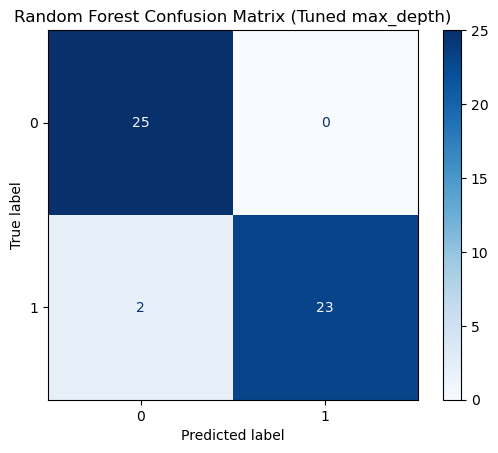

In [21]:
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
best_rf = grid.best_estimator_

rf_pred = best_rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

print("Random Forest Accuracy:", rf_acc)

cm = confusion_matrix(y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Random Forest Confusion Matrix (Tuned max_depth)")
plt.show()

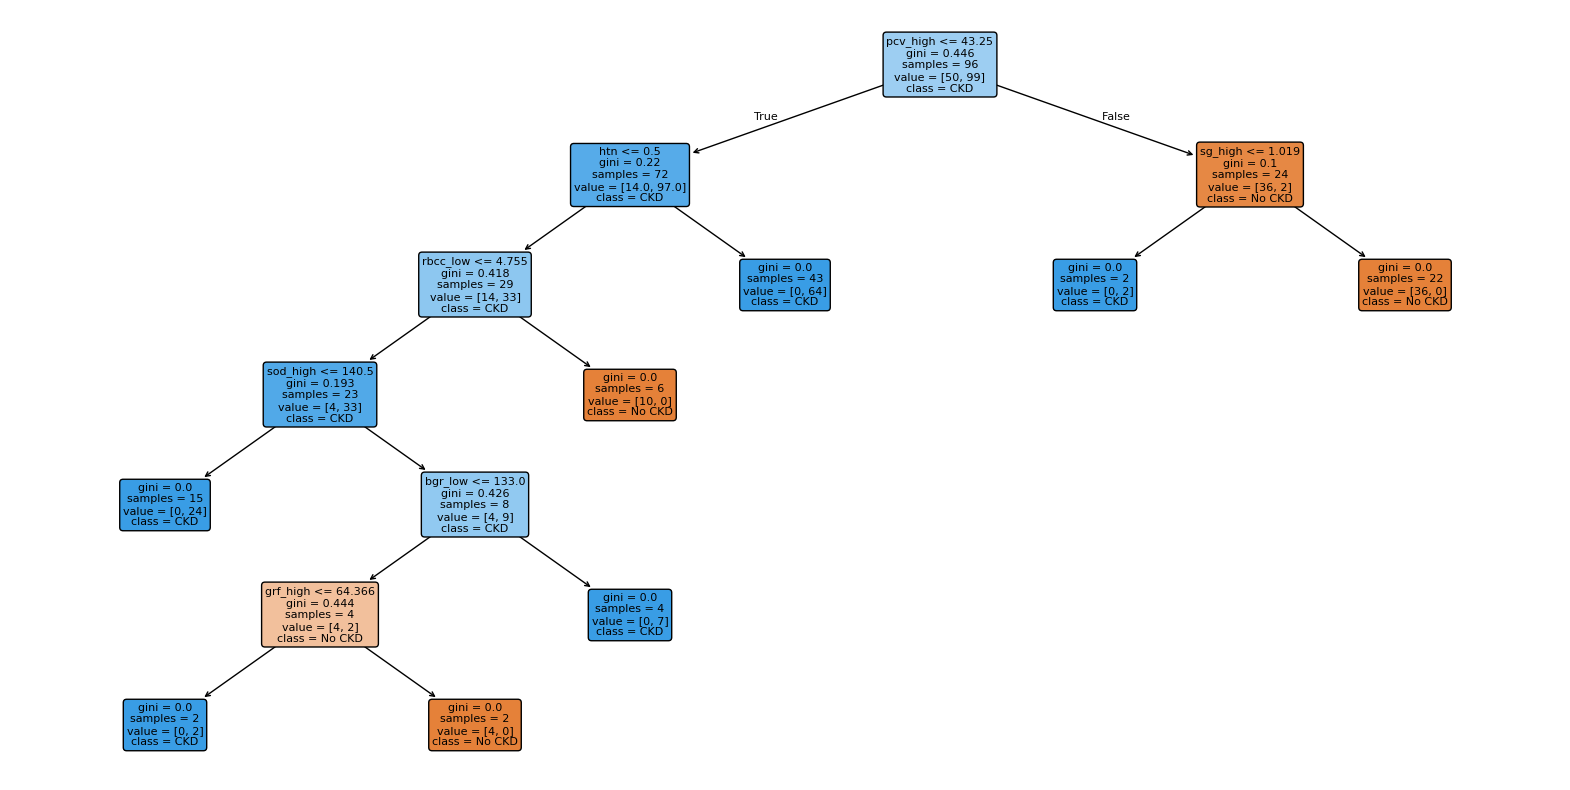

In [23]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
estimator = rf.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(
    estimator,
    feature_names=X.columns,
    class_names=["No CKD", "CKD"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()

**Analysis**

Our linear regression and k-fold Classification found that three variables in particular - blood alum, ratio of blood urea, and blood sugar levels - were the most relevant at predicting the presence of CKD in the bloodstream. Lasso regression, which was applied next, expressed a predictive rate of .96, which is very high. Our confusion matrix indicated that the model was able to predict True positives and True negatives at about the same rate, had no false positives, but 2 false negatives, indicating that while our alpha, or probability of commiting a type 1 error, was correctly calculated but the beta may be sightly loose causing a slight tendency towards Type 2 errors. 

When comparing our results to the research paper, they are comparable, with a rate of .96 compared to the researcher's .98. The slightly lower rate of prediction may stem from the continuous value approach introducing more variables and making calculations slightly more complex, or may simply stem from having less specific lasso capabilities.

Our tree visualization prioritizes variables such as gini, bgr and rbcc, variables that also had high coefficients and p-values in the regression.



**Conclusion**

CKD is a dangerous infection that is very common and very difficult to detect due to its invisibility in early stages. Utilizing several common machine learning techniques, such as regression, lasso regression, and random trees, predictive techniques can tell if a person has CKD with 96% accuracy. This is 